In [11]:
import os
import pandas as pd
import sys
import io
import pickle
import tarfile
import torch

from lcapt.lca import LCAConv2D
import torch.nn.functional as F
import torch.nn as nn
import pprint
from pathlib import Path
from typing import List
from PIL import Image 

import matplotlib.pyplot as plt

from data_utils import *
from lca_utils_ep_fast import *
%matplotlib inline
plt.style.use('tableau-colorblind10') 

In [12]:
rcnn_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/CNN/2024-11-04/run_0'

pretrained_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/pretrained/2024-11-04/run_0'
tuned_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/finetune/2024-11-04/run_0'
learndict_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/learn/2024-11-04/run_1'

rcnn_results = pd.read_csv(f'{rcnn_path}/results.csv', index_col=0) if os.path.exists(f'{rcnn_path}/results.csv') else print('No standard RCNN results found')
pretrained_results = pd.read_csv(f'{pretrained_path}/results.csv', index_col=0) if os.path.exists(f'{pretrained_path}/results.csv') else print('No pretrained dictionary results found')
tuned_results = pd.read_csv(f'{tuned_path}/results.csv', index_col=0) if os.path.exists(f'{tuned_path}/results.csv') else print('No tuning dictionary results found')
learndict_results = pd.read_csv(f'{learndict_path}/results.csv', index_col=0) if os.path.exists(f'{learndict_path}/results.csv') else print('No full dictionary learning results found')

No standard RCNN results found


In [15]:
results_list = [pretrained_results, tuned_results, learndict_results]

In [34]:
colors = [
    '#000000',  # Black
    '#0072B2',  # Blue
    '#CC79A7',  # Reddish-purple
    '#009E73',  # Green
    '#D55E00',  # Vermillion
    '#F0E442',  # Yellow
    '#56B4E9',  # Sky blue
    '#E69F00',  # Orange
]

def plot_metrics(results_list, key1, key2, metric_name='Dictionary Loss', labels=None, colors = colors):
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(results_list))]

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over each model's results DataFrame and plot key1 and key2 metrics
    for i, results_df in enumerate(results_list):
        model_metric1 = results_df[key1].tolist()
        model_metric2 = results_df[key2].tolist()
        
        # Create a range for the x-axis (epochs or iterations)
        epochs = range(1, len(model_metric1) + 1)
        
        # Plot training (key1) and validation (key2) metrics with different line styles
        ax.plot(epochs, model_metric1, colors[i], label=f'{labels[i]} - {key1}', linestyle='--')
        ax.plot(epochs, model_metric2, colors[i], label=f'{labels[i]} - {key2}', linestyle='-')

    # Set plot labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)
    ax.set_title(f'LCA-RCNN {metric_name}')
    
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Suppose we have a list of DataFrames where each DataFrame contains columns 'train_loss' and 'val_loss'
# results_list = [model1_results, model2_results, model3_results]
# plot_metrics(results_list, key1='train_loss', key2='val_loss', metric_name='Loss', labels=['Model 1', 'Model 2', 'Model 3'])


In [35]:
pretrained_results.tail(1)

,Train Accuracy,Validation Accuracy,Train Sparsity,Validation Sparsity,Train Reconstruction Error,Validation Reconstruction Error
41,66.56,67.54,0.064697,0.065474,-0.000416,0.000372


In [36]:
tuned_results.tail(1)

,Train Accuracy,Validation Accuracy,Train Sparsity,Validation Sparsity,Train Reconstruction Error,Validation Reconstruction Error
37,67.232,67.35,0.06292,0.062618,0.006956,0.000185


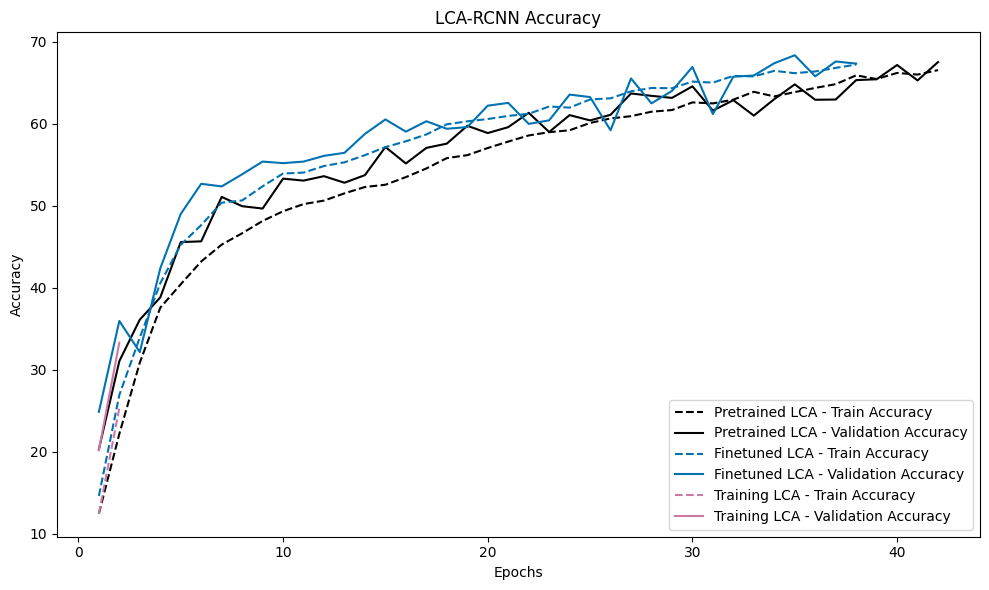

In [ ]:
acc_plot = plot_metrics(results_list, key1='Train Accuracy', key2='Validation Accuracy', metric_name='Accuracy', labels=['Pretrained LCA', 'Finetuned LCA', 'Training LCA'])

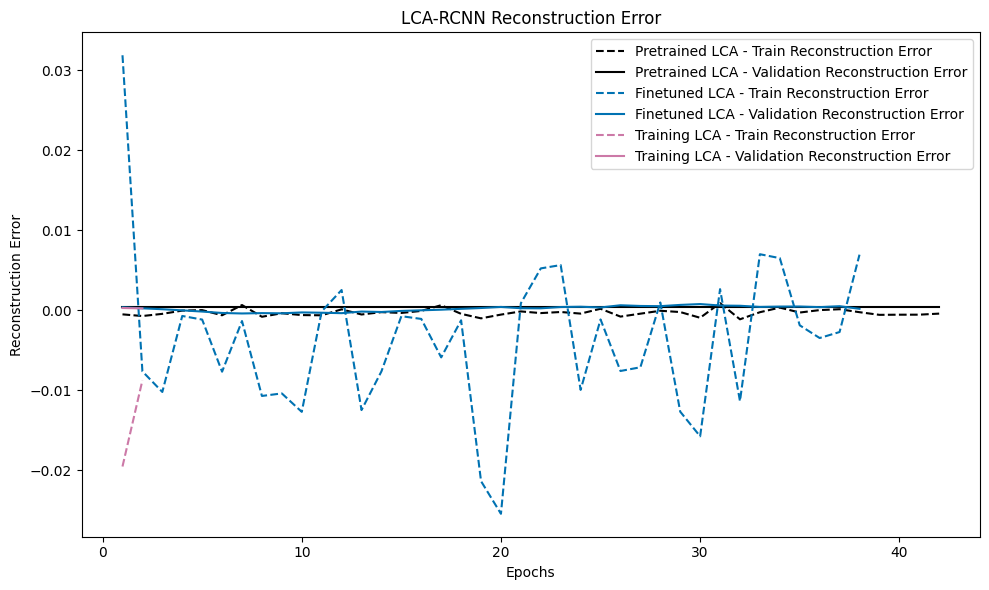

In [40]:
reconerr_plot = plot_metrics(results_list, key1='Train Reconstruction Error', key2='Validation Reconstruction Error', metric_name='Reconstruction Error', labels=['Pretrained LCA', 'Finetuned LCA', 'Training LCA'])

LCA (pretrained) frontend

In [31]:
pretrained_model = torch.load(pretrained_path + '/model.pt', map_location=torch.device('cpu'))
pretrained_weights = make_feature_grid(pretrained_model.lca.weights)
plt.figure(figsize=(10, 10))
plt.imshow(pretrained_weights.float().cpu().numpy())

/tmp/ipykernel_719255/129792735.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load(pretrained_path + '/model.pt', map_location=torch.device('c

FileNotFoundError: [Errno 2] No such file or directory: '/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/pretrained/2024-11-03/run_0/model.pt'

Model Analysis

In [ ]:
pretrained_model = torch.load(pretrained_path + '/model.pt', map_location=torch.device('cpu'))
pretrained_weights = make_feature_grid(pretrained_model.lca.weights)
plt.figure(figsize=(10, 10))
plt.imshow(pretrained_weights.float().cpu().numpy())

hyperparams = read_hyperparameters(pretrained_path + '/hyperparameters.txt')
torch.manual_seed(hyperparams['seed'])

/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/class/CNN/2024-10-07/run_13
Loaded model from /storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/class/CNN/2024-10-07/run_13


/tmp/ipykernel_3874227/2483788573.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'{model_path}/model.pt', map_location=torch.device('cpu'))


P_CNN(
  (synapses): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [12]:
make_pools(hyperparams['pools'])

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [24]:
init_lca = LCAConv2D(
                hyperparams['channels'][0],
                3,
                f"/storage/jr3548@drexel.edu/eplcanet/results/{hyperparams['task']}/eplcanet",
                hyperparams['kernels'][0],
                hyperparams['strides'][0],
                hyperparams['lca_lambda'],
                hyperparams['tau'],
                hyperparams['eta'],
                hyperparams['lca_iters'],
                pad="valid",
                return_vars=["acts", "recon_errors", "states"],
                input_zero_mean=True,
                input_unit_var=True,
                nonneg=True,
                req_grad=False if hyperparams['dict_loss']=='recon' else True,
                #weight_init=(torch.nn.init.kaiming_uniform_, {}),
            )

In [25]:
init_lca.get_weights().detach().numpy()

array([[[[ 0.04035558, -0.04190758,  0.04851783, -0.00887705,
           0.07775947],
         [ 0.04192541, -0.02002589, -0.17490627,  0.04016142,
          -0.20650056],
         [ 0.02292211,  0.011555  , -0.03864482,  0.17826663,
           0.01160361],
         [ 0.07526313,  0.07696018, -0.11287192, -0.06931664,
           0.2524767 ],
         [-0.26781976, -0.01180948, -0.01378527,  0.14350124,
          -0.01654803]],

        [[ 0.04651849, -0.00834217, -0.10595355, -0.10751092,
          -0.08979283],
         [-0.21816686, -0.12731354,  0.04143243,  0.12966812,
           0.00856114],
         [-0.08408992,  0.08023584, -0.0692073 , -0.03893651,
          -0.10330996],
         [-0.05588798, -0.2284793 ,  0.07765969,  0.07017458,
           0.03483116],
         [ 0.09087781,  0.07708755,  0.00768801,  0.01844382,
           0.01328139]],

        [[ 0.10006709,  0.13322707,  0.14602418,  0.11046118,
          -0.04296531],
         [-0.00773576, -0.03565201,  0.11095508,  

In [26]:
model.synapses[0].weights.detach().numpy()

array([[[[ 0.04035558, -0.04190758,  0.04851783, -0.00887705,
           0.07775947],
         [ 0.04192541, -0.02002589, -0.17490627,  0.04016142,
          -0.20650056],
         [ 0.02292211,  0.011555  , -0.03864482,  0.17826663,
           0.01160361],
         [ 0.07526313,  0.07696018, -0.11287192, -0.06931664,
           0.2524767 ],
         [-0.26781976, -0.01180948, -0.01378527,  0.14350124,
          -0.01654803]],

        [[ 0.04651849, -0.00834217, -0.10595355, -0.10751092,
          -0.08979283],
         [-0.21816686, -0.12731354,  0.04143243,  0.12966812,
           0.00856114],
         [-0.08408992,  0.08023584, -0.0692073 , -0.03893651,
          -0.10330996],
         [-0.05588798, -0.2284793 ,  0.07765969,  0.07017458,
           0.03483116],
         [ 0.09087781,  0.07708755,  0.00768801,  0.01844382,
           0.01328139]],

        [[ 0.10006709,  0.13322707,  0.14602418,  0.11046118,
          -0.04296531],
         [-0.00773576, -0.03565201,  0.11095508,  

In [27]:
# Are initialized LCA and loaded weights the same??
print('Dictionary loss function: ' + hyperparams['dict_loss'])
print('Training algorithm: ', hyperparams['alg'])
print('\nLearned dictionary same as init: ', (init_lca.get_weights().detach().numpy() == model.synapses[0].weights.detach().numpy()))

feat_grid = make_feature_grid(init_lca.get_weights())
feat_grid_2 = make_feature_grid(model.synapses[0].weights)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot the first feature grid in the first subplot
axes[0].imshow(feat_grid.float().cpu().numpy())
axes[0].set_title("Initial Weights")
axes[0].axis('off')  # Hide axis labels

# Plot the second feature grid in the second subplot
axes[1].imshow(feat_grid_2.float().cpu().numpy())
axes[1].set_title("Learned LCA Weights")
axes[1].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


Dictionary loss function: class
Training algorithm:  BPTT

Learned dictionary same as init:  [[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]


 [[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  Tru

In [13]:
acc_plots = plot_metrics(model, 'train_acc', 'test_acc', 'Accuracy (EP)')

TypeError: plot_metrics() missing 1 required positional argument: 'key2'

### Compare Models

In [20]:
# Compare two models
model_path_1 = class_path_ep
model_path_2 = class_path_ep

model_type_1 = model_path_1.split('/')[-4]
model_type_2 = model_path_2.split('/')[-4]

model_1 = torch.load(f'{model_path_1}/model.pt', map_location=torch.device('cpu'))
model_2 = torch.load(f'{model_path_2}/model.pt', map_location=torch.device('cpu'))

/tmp/ipykernel_4099168/436647142.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1 = torch.load(f'{model_path_1}/model.pt', map_location=torch.device('cpu'))
/tmp/

Weights the same? True


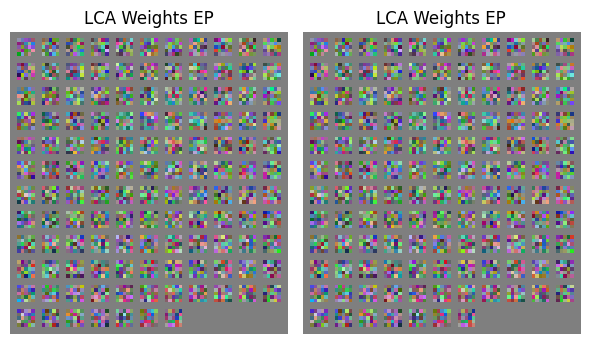

In [21]:
print('Weights the same?', (model_1.synapses[0].weights.detach().numpy() == model_2.synapses[0].weights).all().detach().numpy())

feat_grid = make_feature_grid(model_1.synapses[0].weights)
feat_grid_2 = make_feature_grid(model_2.synapses[0].weights)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot the first feature grid in the first subplot
axes[0].imshow(feat_grid.float().cpu().numpy())
axes[0].set_title(f"LCA Weights {model_type_1}")
axes[0].axis('off')  # Hide axis labels

# Plot the second feature grid in the second subplot
axes[1].imshow(feat_grid_2.float().cpu().numpy())
axes[1].set_title(f"LCA Weights {model_type_2}")
axes[1].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


### Back Propagation Training

In [21]:
files = list_files(combo_path_bp, extension='.txt')
print(files)
print()
hyperparams_bp = read_hyperparameters(combo_path_bp + '/hyperparameters.txt')

['hyperparameters.txt']



In [23]:
files = list_files(combo_path_bp, extension='.png')
print(files)

['recon_error.png', 'lca_weights.png', 'sparsity.png', 'accuracy.png']


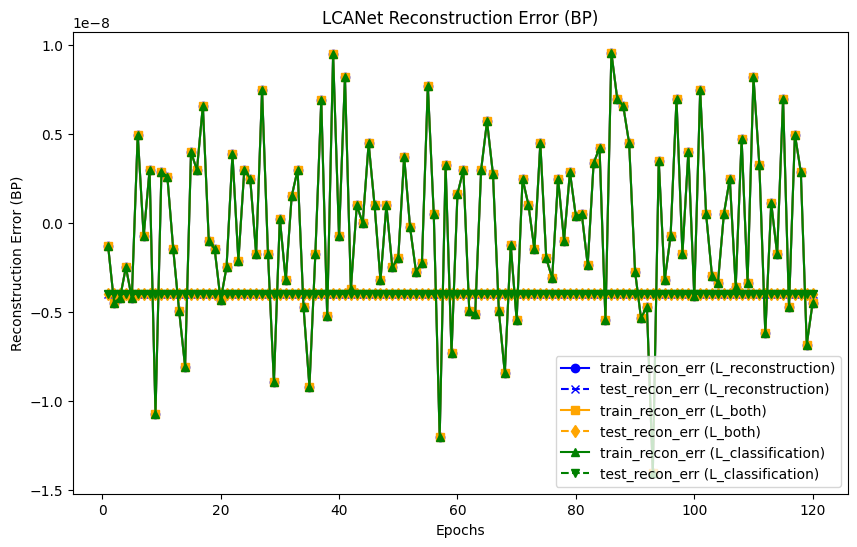

In [24]:
model_checkpoint = combo_checkpoint_bp
recon_plots = plot_metrics(model_checkpoint, model_checkpoint, model_checkpoint, 'train_recon_err', 'test_recon_err', 'Reconstruction Error (BP)')

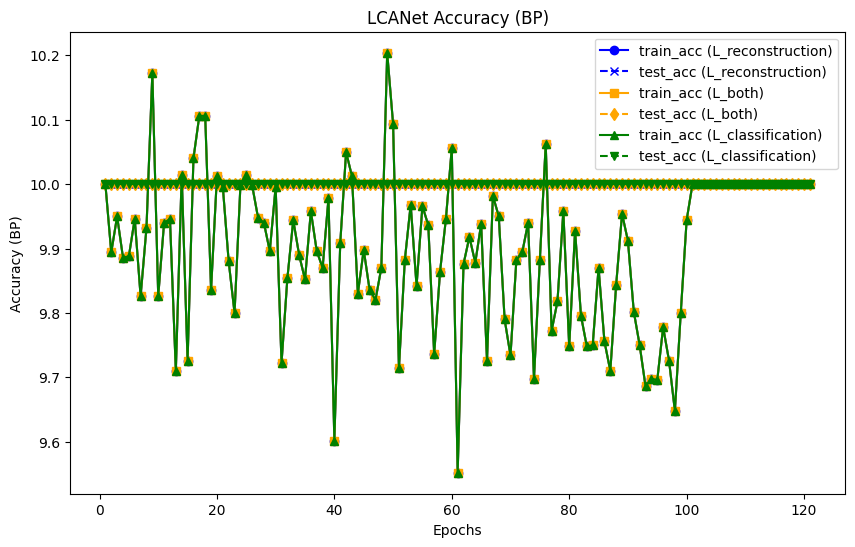

In [25]:
acc_plots = plot_metrics(model_checkpoint, model_checkpoint, model_checkpoint, 'train_acc', 'test_acc', 'Accuracy (BP)')

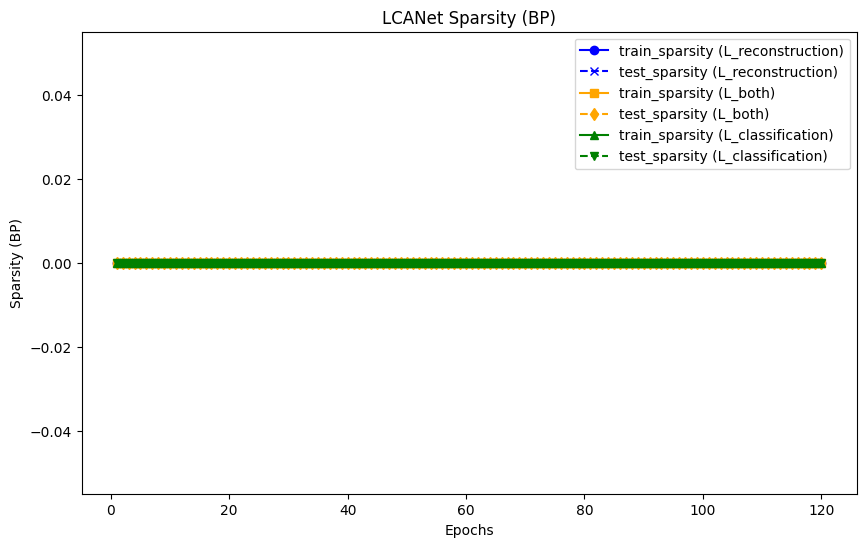

In [26]:
sparsity_plots = plot_metrics(model_checkpoint, model_checkpoint, model_checkpoint, 'train_sparsity', 'test_sparsity', 'Sparsity (BP)')

### Equilibrium Propagation Training

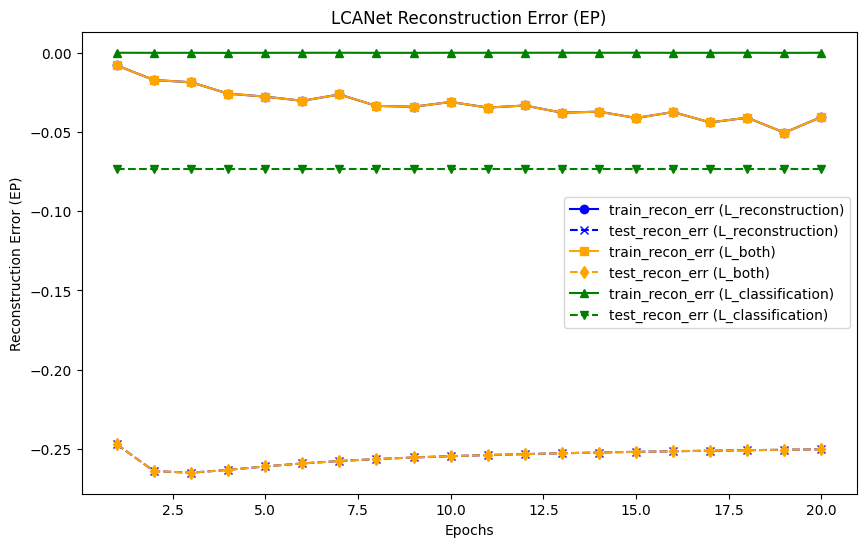

In [35]:
ep_recon_plots = plot_metrics(recon_checkpoint_ep, recon_checkpoint_ep, class_checkpoint_ep, 'train_recon_err', 'test_recon_err', 'Reconstruction Error (EP)')

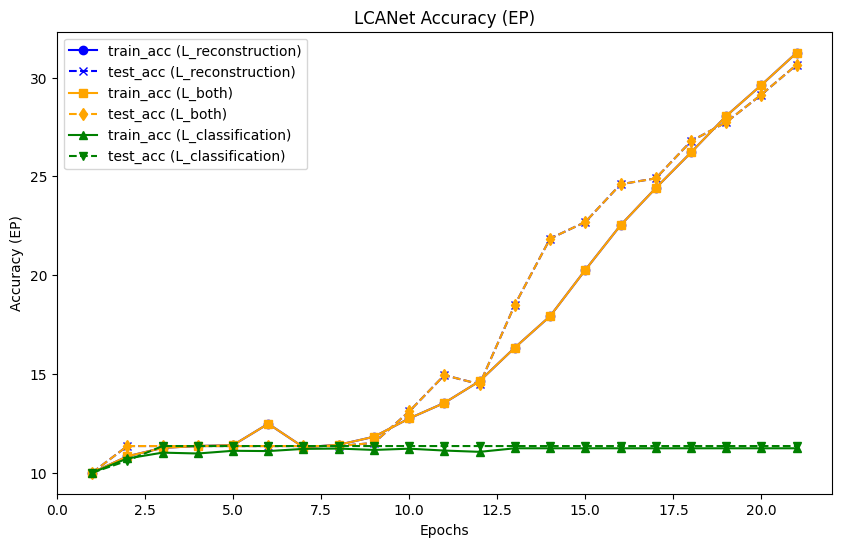

In [36]:
ep_acc_plots = plot_metrics(recon_checkpoint_ep, recon_checkpoint_ep, class_checkpoint_ep, 'train_acc', 'test_acc', 'Accuracy (EP)')

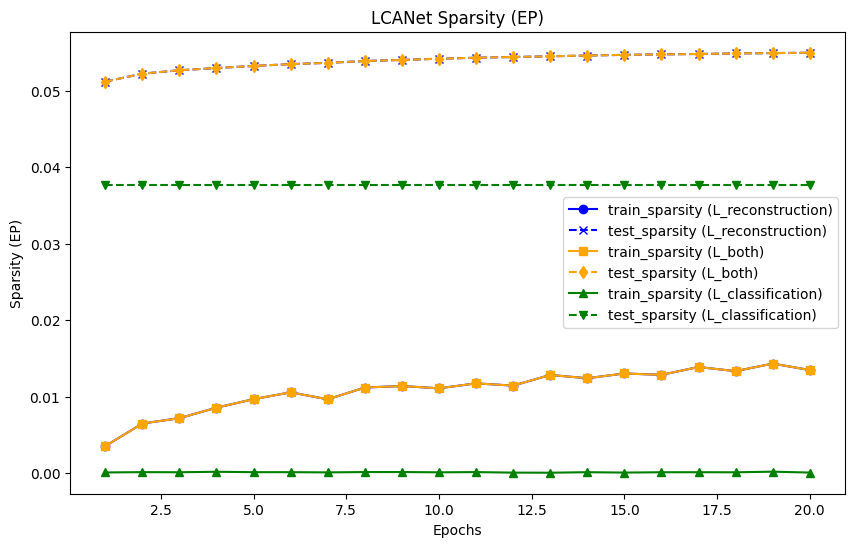

In [37]:
ep_sparsity_plots = plot_metrics(recon_checkpoint_ep, recon_checkpoint_ep, class_checkpoint_ep, 'train_sparsity', 'test_sparsity', 'Sparsity (EP)')